# 1. Import Dependencies and Data

In [ ]:
#!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
#!pip list

In [3]:
# Bringing in tensorflow
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
import tensorflow as tf
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
from zipfile import ZipFile

In [3]:
zf = ZipFile("Saint Remy.zip")
zf.extractall(path = 'Saint_Remy/')
zf.close()
print("... done")

... done


# 2. Viz Data and Build Dataset

In [2]:
# Do some data transformation
import numpy as np

In [3]:
import cv2
import os

# Specify the directory where your Van Gogh paintings are stored
data_dir = '/home/notebooks/sundar/Saint_Remy/Saint Remy'

# Create a list to store image file paths
image_paths = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_paths.append(os.path.join(data_dir, filename))

In [30]:
def preprocess_image(image):
    # Resize the image to your desired dimensions
    image = cv2.resize(image, (64, 64))
    
    # Normalize pixel values to the range [0, 1]
    image = image / 255.0

    return image

In [31]:
# Load and preprocess the images
images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = preprocess_image(image)
    images.append(image)

# Convert the list of preprocessed images to a TensorFlow dataset
ds = tf.data.Dataset.from_tensor_slices(images)

In [32]:
ds = ds.cache()
ds = ds.shuffle(len(image_paths))  # Use the number of images as the buffer size
ds = ds.batch(64)
ds = ds.prefetch(64)

In [33]:
ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float64, name=None)>

In [34]:
ds.as_numpy_iterator().next().shape

(64, 64, 64, 3)

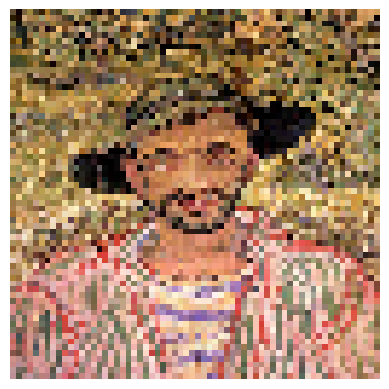

In [35]:
# Extract one batch (one image)
batch = next(iter(ds.take(1)))

# Extract the image from the batch
first_image = batch[0]

# Display the image using Matplotlib
plt.imshow(first_image.numpy())
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [36]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [47]:
def build_generator():
    model = Sequential()

    # Input shape is modified to match the desired shape (512, 512, 3)
    model.add(Dense(16 * 16 * 256, input_dim=256))  # Assuming input_dim is 256
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 256)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(256, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(64, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(32, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to three channels (RGB) and the desired output shape
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    #model.add(Reshape((512, 512, 3)))  # Reshape to the desired output shape

    return model

In [48]:
generator = build_generator()

In [49]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 65536)             16842752  
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 65536)             0         
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 256)       0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 256)       1638656   
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                      

In [50]:
imagee = generator.predict(np.random.randn(4,256))

1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 30ms/step


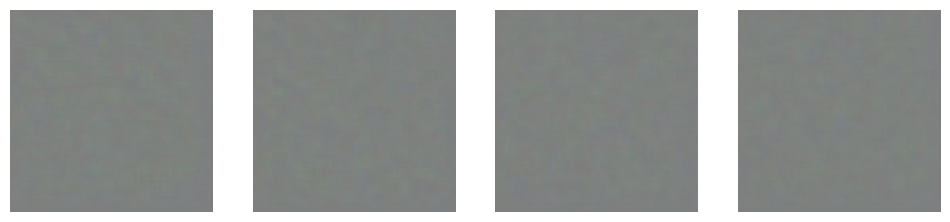

In [51]:
# Generate new paintings
generated_img = generator.predict(np.random.randn(4,256))

# # Assuming generated_img contains the generated images
# firstgen_image = generated_img[0]

# # Display the first generated image
# plt.imshow(firstgen_image)
# plt.axis('off')  # Turn off axis labels and ticks
# plt.show()

# Create a subplot with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Loop through the generated images and display them in the subplot
for i in range(4):
    axs[i].imshow(generated_img[i])
    axs[i].axis('off')

# Show the generated images in one row
plt.show()

In [52]:
generated_img.shape

(4, 64, 64, 3)

### 3.3 Build Discriminator

In [56]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (64,64,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [57]:
discriminator = build_discriminator()

In [58]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 60, 60, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 60, 60, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 56, 56, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 56, 56, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 52, 128)      

In [59]:
imagee = generated_img[0]

In [60]:
imagee.shape

(64, 64, 3)

In [62]:
discriminator.predict(generated_img)

1/1 [==============================] - 0s 190ms/step


array([[0.4999333 ],
       [0.49990848],
       [0.4997991 ],
       [0.500099  ]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [63]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [64]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [65]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [92]:
class VanGoghGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((64, 256)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((64, 256)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [93]:
# Create instance of subclassed model
vangoghgan = VanGoghGAN(generator, discriminator)

In [94]:
# Compile the model
vangoghgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [95]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [96]:
#Custom callback AN(3 images every 80 epochs)
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=256, save_interval=80):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_interval = save_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_interval == 0:
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = array_to_img(generated_images[i])
                img.save(os.path.join('gen_paintings', f'generated_img_epoch{epoch + 1}_{i}.jpg'))


### 4.3 Train 

In [97]:
# Recommend 2000 epochs
hist = vangoghgan.fit(ds, epochs=4000, callbacks=[ModelMonitor()])

Epoch 1/4000
3/3 [==============================] - 2s 228ms/step - d_loss: 0.2748 - g_loss: 0.0033
Epoch 2/4000
3/3 [==============================] - 1s 228ms/step - d_loss: 0.2708 - g_loss: 0.0033
Epoch 3/4000
3/3 [==============================] - 1s 229ms/step - d_loss: 0.2800 - g_loss: 0.0035
Epoch 4/4000
3/3 [==============================] - 1s 229ms/step - d_loss: 0.2738 - g_loss: 0.0035
Epoch 5/4000
3/3 [==============================] - 1s 229ms/step - d_loss: 0.2729 - g_loss: 0.0034
Epoch 6/4000
3/3 [==============================] - 1s 228ms/step - d_loss: 0.2639 - g_loss: 0.0034
Epoch 7/4000
3/3 [==============================] - 1s 229ms/step - d_loss: 0.2720 - g_loss: 0.0036
Epoch 8/4000
3/3 [==============================] - 1s 229ms/step - d_loss: 0.2705 - g_loss: 0.0038
Epoch 9/4000
3/3 [==============================] - 1s 228ms/step - d_loss: 0.2789 - g_loss: 0.0035
Epoch 10/4000
3/3 [==============================] - 1s 229ms/step - d_loss: 0.2628 - g_loss: 0.0038

### 4.4 Review Performance

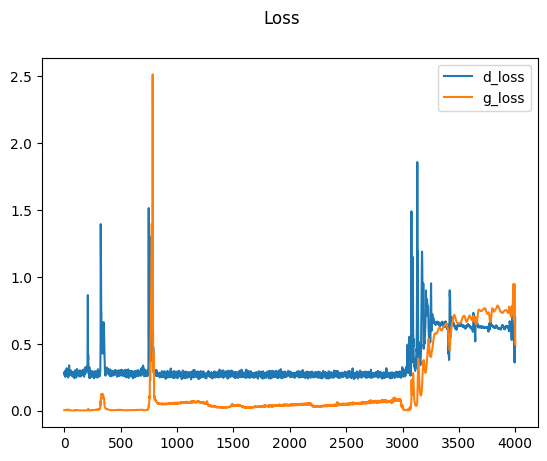

In [98]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [211]:
#generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [99]:
imgs = generator.predict(tf.random.normal((16, 256)))

1/1 [==============================] - 0s 40ms/step


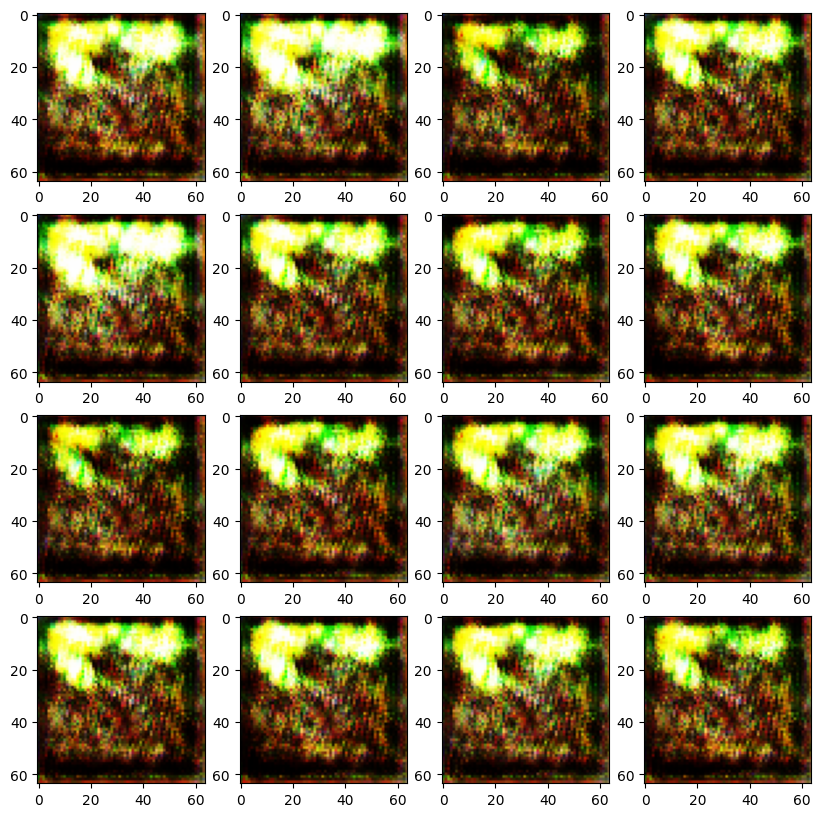

In [100]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])
plt.show()

### 5.2 Save the Model

In [101]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')